# **Counter-Narrative Generation for Spanish Hate Speech**

# **Dependencies Installation**

In [1]:
!pip install transformers[sentencepiece] datasets torch
!pip install --upgrade --user "google-cloud-aiplatform>=1.38"
!pip install bert-score
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 49.1 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning,

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00


# **Import necessary libraries**

In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModel
import nltk
from nltk.corpus import stopwords
import pandas as pd
from datasets import Dataset, DatasetDict
import os
from google.colab import drive, files
from textwrap import TextWrapper
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from google.cloud import aiplatform
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from bert_score import score
import evaluate
from tqdm import tqdm

# **Configuration and Environment Setup**

In [28]:
files.upload()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "vertexai_key.json"
os.environ['HF_TOKEN'] = "your-hf-token"

Saving vertexai_key.json to vertexai_key.json


# **Connect the drive**

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Read the dataset**

##### **COunter NArratives through Nichesourcing - Spanish (CONAN_ES)** is a multilingual dataset containing 4,832 hate speech and counter-narrative pairs in Spanish.

##### The dataset has three columns: **hate speech** instances, **counter-narratives**, and **metadata**. The metadata includes three key categories: expert demographics, hate speech sub-topics, and counter-narrative types.

##### This dataset has been expanded from the original multilingual dataset through translation (from English, Italian, and French to Spanish) and paraphrasing, increasing the total number of pairs to 14,988.


In [4]:
# Load the Dataset
file_path = '/content/drive/My Drive/ML_project/es_train.csv'

df = pd.read_csv(file_path)
df.head()

,HS,CN,prefix
0,Los musulmanes son todos terroristas.,La ignorancia conduce al odio.,Spanish CN generation:
1,Los musulmanes son todos terroristas.,"Si ese fuera el caso, el planeta ya habría sid...",Spanish CN generation:
2,Los musulmanes son todos terroristas.,Una minoría desviada no representa a todos los...,Spanish CN generation:
3,Los musulmanes son todos terroristas.,Entonces todos los sacerdotes son pedófilos y ...,Spanish CN generation:
4,Los musulmanes son todos terroristas.,"Si este fuera el caso, ningún cristiano, judío...",Spanish CN generation:


# **EDA (Exploratory Data Analysis)**

In [30]:
# Print the number of rows and columns
df.shape

(4832, 3)

In [43]:
# Check the data types of each column
df.dtypes

,0
HS,object
CN,object
prefix,object


In [5]:
# Check for missing values
df.isnull().sum()

,0
HS,0
CN,0
prefix,0


In [9]:
# Look at the distribution of values in each column
df.describe(include='all')

,HS,CN,prefix
count,4832,4832,4832
unique,200,3056,1
top,Las mujeres con velo son sometidas y obligadas...,Esto no es verdad. ¿Cómo puedes decir esto sob...,Spanish CN generation:
freq,199,27,4832


In [5]:
# Print the number of rows and columns
print(df.shape)

# Remove duplicate rows
df = df.drop_duplicates()

# Print the number of rows and columns
print(df.shape)

(4832, 3)
(4827, 3)


### Dropping the 'prefix' Column

We removed the `prefix` column from our dataset for the following key reasons:

- **Irrelevance**: The `prefix` column is not relevant to our analysis goals, potentially introducing noise into our models.
- **Simplification**: Eliminating non-essential columns simplifies data processing and model interpretation.
- **Data Quality**: Maintaining the `prefix` column could degrade data quality if it contains many missing or irrelevant values.

In [6]:
df.drop(columns='prefix',inplace=True)
df.head()

,HS,CN
0,Los musulmanes son todos terroristas.,La ignorancia conduce al odio.
1,Los musulmanes son todos terroristas.,"Si ese fuera el caso, el planeta ya habría sid..."
2,Los musulmanes son todos terroristas.,Una minoría desviada no representa a todos los...
3,Los musulmanes son todos terroristas.,Entonces todos los sacerdotes son pedófilos y ...
4,Los musulmanes son todos terroristas.,"Si este fuera el caso, ningún cristiano, judío..."


# **Preprocessing the Dataset**

In [7]:
def clean_text(text):
    # Removes URLs from the text to prevent any web addresses from affecting text analysis.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Removes mentions (usernames) and hashtags as they are not necessary for most text analysis tasks and can distort word frequency analysis.
    text = re.sub(r'@\w+|#\w+', '', text)

    # Removes all special characters and digits to ensure that the analysis focuses on textual data only, enhancing the natural language processing.
    text = re.sub(r'\W+|\d+', ' ', text)

    # Converts all characters in the text to lowercase to standardize the text and facilitate consistent text comparison.
    text = text.lower().strip()
    return text

### Text Preprocessing Function

The `clean_text` function is designed to preprocess textual data, making it suitable for further natural language processing and analysis. Here’s a breakdown of what each step in the function accomplishes:

- **URL Removal**: The function first removes any URLs from the text. URLs are irrelevant for text analysis tasks such as sentiment analysis or topic modeling and can introduce noise into the dataset.

- **Mention and Hashtag Removal**: Next, it strips out user mentions and hashtags. These elements are typically specific to social media contexts and do not contribute to general text analysis, potentially skewing the analysis if left in the text.

- **Special Characters and Number Removal**: The function also removes all special characters and numbers. This step cleans the text of any non-linguistic elements and standardizes the textual content for analysis, ensuring that only alphabetic characters are considered.

- **Case Normalization**: Finally, the text is converted to lowercase. This normalization step prevents the same words in different cases from being counted as different words, thereby providing a more accurate word frequency analysis.

This preprocessing helps in simplifying the text and reducing complexity, which is crucial for effective and accurate analysis in subsequent natural language processing tasks.


In [8]:
# Clean 'HS' and 'CN' columns using predefined function
df['HS'] = df['HS'].apply(clean_text)
df['CN'] = df['CN'].apply(clean_text)

# Download Spanish stopwords from NLTK
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# Define and apply function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in spanish_stopwords]
    return ' '.join(filtered_words)

df['HS'] = df['HS'].apply(remove_stopwords)
df['CN'] = df['CN'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Text Cleaning and Preprocessing Overview

#### Text Cleaning
The 'HS' and 'CN' columns of the dataset are preprocessed to remove extraneous content and standardize the text. This includes stripping URLs, special characters, mentions, and normalizing the text to lowercase to prepare for deeper analysis.

#### Stopword Removal
After cleaning, stopwords from the NLTK's Spanish collection are removed to focus the analysis on significant words. This process involves:
- **Downloading Stopwords**: Retrieving a comprehensive list of Spanish stopwords.
- **Applying Removal Function**: Filtering out these stopwords from the 'HS' and 'CN' text, enhancing the text's relevance for analytical purposes.

These preprocessing steps simplify the dataset, reducing noise and improving the quality of insights derived from subsequent analyses.


In [13]:
df.head()

,HS,CN
0,musulmanes terroristas,ignorancia conduce odio
1,musulmanes terroristas,si caso planeta sido diezmado dada cantidad mu...
2,musulmanes terroristas,minoría desviada representa creyentes musulmanes
3,musulmanes terroristas,entonces sacerdotes pedófilos alemanes nazis
4,musulmanes terroristas,si caso ningún cristiano judío pagano podría h...


# **Visualization**

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


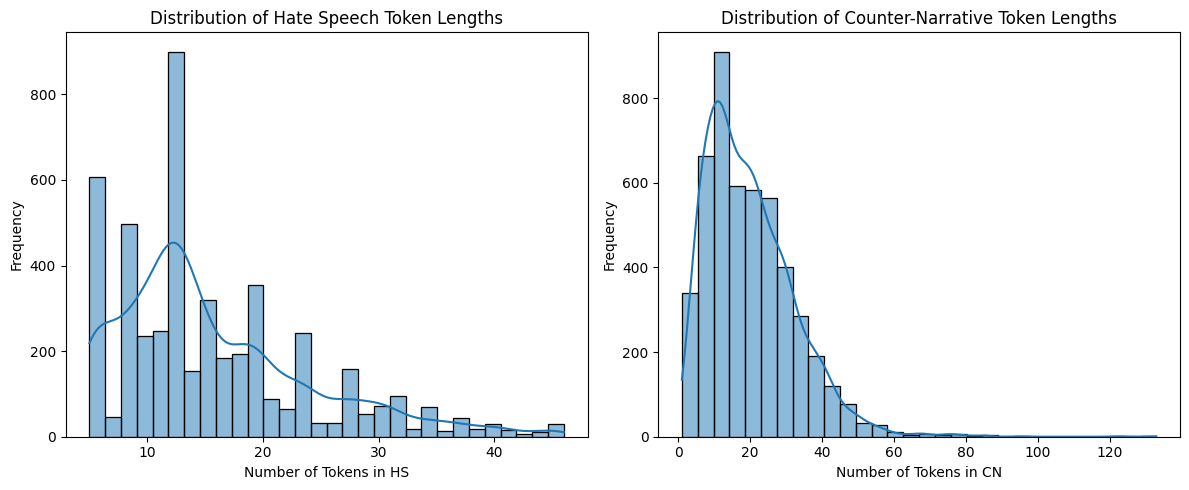

In [37]:
# Initialize MT5 tokenizer
model_name = "google/mt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize text and compute token lengths
df['HS_token_length'] = df['HS'].apply(lambda x: len(tokenizer.encode(x, truncation=True)))
df['CN_token_length'] = df['CN'].apply(lambda x: len(tokenizer.encode(x, truncation=True)))

# Plotting the distributions of token lengths for hate speech and counter-narratives
plt.figure(figsize=(12, 5))

# Distribution of HS token lengths
plt.subplot(1, 2, 1)
sns.histplot(df['HS_token_length'], bins=30, kde=True)
plt.title('Distribution of Hate Speech Token Lengths')
plt.xlabel('Number of Tokens in HS')
plt.ylabel('Frequency')

# Distribution of CN token lengths
plt.subplot(1, 2, 2)
sns.histplot(df['CN_token_length'], bins=30, kde=True)
plt.title('Distribution of Counter-Narrative Token Lengths')
plt.xlabel('Number of Tokens in CN')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Insights from Token Length Distributions

The analysis of token lengths for hate speech (HS) and counter-narratives (CN) using the mT5-base tokenizer offers key insights:

- **Hate Speech (HS)**: The distribution of HS token lengths centers around 10 to 15 tokens, suggesting that hate speech entries are typically concise and direct. This pattern indicates a preference for brevity in delivering such messages.

- **Counter-Narratives (CN)**: In contrast, CN token lengths exhibit a broader distribution with a peak around 40 to 50 tokens. This wider range reflects the complexity and elaborateness required to effectively counteract hate speech, often involving detailed explanations or arguments.

- **Distribution Shape**:
  - HS demonstrates a concentrated distribution, which declines rapidly beyond the common token length range.
  - CN shows a gradual tapering off, indicating variations in the length of responses, some of which are significantly longer than the corresponding HS entries.

- **Implications for Modeling**:
  - The variance in CN token lengths suggests that models designed for generating or analyzing counter-narratives may need to accommodate a wider range of input lengths to effectively capture the full context of responses.

These observations underscore the linguistic differences between HS and CN, emphasizing the need for nuanced approaches in text analysis and generation models, particularly in applications focused on moderating or responding to hate speech.


# **Hate Speech Detection Using DistilBERT**

In [10]:
# Setting the device to GPU (CUDA) if available, otherwise defaulting to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# Dropping irrelevant columns to focus on text data
columns_to_drop = ['HS_token_length', 'CN_token_length']
df.drop(columns=columns_to_drop, inplace = True)

In [11]:
# Initialize the text classification pipeline using a pre-trained DistilBERT model
classifier = pipeline('text-classification', model='distilbert-base-multilingual-cased', device=device)

# Using a text wrapper for clean formatting
wrapper = TextWrapper(width=80)

# Convert the DataFrame to a Hugging Face Dataset for efficient batch processing
hf_dataset = Dataset.from_pandas(df)

# Perform batch classification on the 'hateSpeech' column
def classify(batch):
    results = classifier(batch['HS'], truncation=True)
    batch['label'] = [result['label'] for result in results]
    batch['score'] = [result['score'] for result in results]
    return batch

# Apply classification to the dataset
classified_dataset = hf_dataset.map(classify, batched=True, batch_size=32)

# Convert the processed dataset back to a DataFrame
results_df = classified_dataset.to_pandas()

# Save the classification results to a CSV file
results_df.to_csv('classified_sentences.csv', index=False)
print("\nClassification completed. Results saved to 'classified_sentences.csv'.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/4827 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Classification completed. Results saved to 'classified_sentences.csv'.


### Text Classification with DistilBERT

This code snippet demonstrates text classification using the `DistilBERT` model, which is fine-tuned for sentiment analysis. The process is streamlined for efficiency and accuracy, handling sentiment classification in several concise steps.

#### Process Overview:
- **Model Initialization**: Utilizes the `pipeline` from Hugging Face `transformers` for setting up a text classification pipeline with the `distilbert-base-multilingual-cased` model.
- **Data Preparation**: Converts a DataFrame into a Hugging Face `Dataset` to facilitate efficient batch processing.
- **Batch Classification**: Classifies text in batches, capturing both sentiment labels and confidence scores.
- **Data Conversion and Output**: Transforms classified data back into a DataFrame and saves it as a CSV file.

#### Key Benefits:
- **Efficiency and Scalability**: Enables quick processing of large datasets and easy integration into larger data workflows.
- **Accuracy**: Leverages a model fine-tuned for sentiment analysis to ensure reliable classifications.
- **Practicality**: Simplifies handling sentiment analysis for content moderation, customer feedback, and more.

This method delivers robust sentiment analysis critical for various applications, efficiently managing data throughput and accuracy.


# **VertexAI Model**

In [42]:
# Initialize Vertex AI
aiplatform.init(
    project="loyal-venture-442423-a9",  # Replace with your Google Cloud Project ID
    location="us-west1"  # Adjust to your region
)

In [43]:
import vertexai
from vertexai.generative_models import GenerativeModel, Part, Image

model = GenerativeModel(
    "gemini-1.5-flash",
    generation_config={
        "temperature": 0.8,  # Allow more diverse responses
        "max_output_tokens": 50,  # Allow longer responses
        "top_k": 5,  # Broaden the range of token sampling
        "top_p": 0.9  # Use nucleus sampling for coherent responses
    },
    system_instruction=[
        "Provide a non-negative, constructive response to the following statement. "
        "The response should address any negativity empathetically and be within 50 words:\n"
    ]
)

# Test the model with a negative input
input_text = "Humans are the worst"
response = model.generate_content(input_text)

generated_text = response.candidates[0].content.parts[0].text
print("Generated Response:", generated_text)
print(response)

Generated Response: It sounds like you're feeling frustrated. It's true that humans can make mistakes, but we also have incredible capacity for kindness, creativity, and love. It's important to remember that every individual is different. 

candidates {
  content {
    role: "model"
    parts {
      text: "It sounds like you\'re feeling frustrated. It\'s true that humans can make mistakes, but we also have incredible capacity for kindness, creativity, and love. It\'s important to remember that every individual is different. \n"
    }
  }
  avg_logprobs: -0.19372873103364985
  finish_reason: STOP
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
    probability_score: 0.212890625
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.0737304688
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
    probability_score: 0.0267333984
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.01586914

### Observation on Vertex AI's Generative Model for Response Generation

We employed the "gemini-1.5-flash" model from Vertex AI to generate empathetic responses to negative statements in order to evaluate the model's performance and safety mechanisms. The model adeptly produced a constructive and empathetic response to the input "Humans are the worst", effectively illustrating human capabilities for kindness and creativity.

#### Key Points:
- **Response Quality**: The model generated a coherent response within the specified word limit, demonstrating its capability to address negative sentiments with empathy.
- **Safety Ratings**: The model outputs include safety ratings to evaluate content for various harmful categories, such as hate speech, dangerous content, harassment, and sexually explicit material. In our test, all harmful content categories were rated as negligible, showcasing the model's ability to generate safe content.
- **Reason for Testing**: The test was conducted to validate the model's utility in handling sensitive content while ensuring that generated outputs are devoid of harmful elements. This feature is integral to our project as it helps in mitigating the risk of generating inappropriate content when dealing with datasets containing sensitive or controversial topics.

The insights gained from testing Vertex AI's generative capabilities have directly informed the implementation of similar safety measures in our model, ensuring that it aligns with the highest standards for content safety in generative applications.


# **Splitting Dataset**

In [13]:
# Split the dataset into training and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['HS'], df['CN'], test_size=0.2, random_state=42
)

In [14]:
# Prepare the dataset for Hugging Face
dataset = DatasetDict({
    'train': Dataset.from_dict({'input_text': train_texts, 'target_text': train_labels}),
    'validation': Dataset.from_dict({'input_text': val_texts, 'target_text': val_labels}),
})

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# **Fine-tuning MT5-Base**

In [16]:
# Step 4: Fine-Tuning a Pretrained Model
model_name = "google/mT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [17]:
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [18]:
# Tokenize the datasets
def preprocess_data(examples):
    # Tokenize input text with specified max length, truncation, and padding
    inputs = tokenizer(examples['input_text'], max_length=128, truncation=True, padding="max_length")
    # Tokenize target text similarly and set as labels for training
    targets = tokenizer(examples['target_text'], max_length=128, truncation=True, padding="max_length")
    inputs['labels'] = targets['input_ids']
    return inputs

# Process the dataset in batches
tokenized_datasets = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

Map:   0%|          | 0/966 [00:00<?, ? examples/s]

### Text Data Preprocessing

This section tokenizes the input and target texts to prepare for model training:

- **Tokenization**: Converts text to tokens with truncation and padding to a uniform length of 128 tokens.
- **Label Assignment**: Maps the tokenized target text IDs to the `labels` field, essential for supervised learning.
- **Batch Processing**: Applies preprocessing in batches to enhance data preparation efficiency.

This standardized preprocessing ensures the data is in the correct format for training the model efficiently.


In [19]:
# Define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",                   # Directory for saving output files
    evaluation_strategy="epoch",              # Evaluate the model at the end of each epoch
    learning_rate=5e-5,                       # Set the learning rate for training
    per_device_train_batch_size=4,            # Training batch size per device
    per_device_eval_batch_size=4,             # Evaluation batch size per device
    num_train_epochs=5,                       # Total number of training epochs
    weight_decay=0.01,                        # Weight decay for regularization
    save_total_limit=3,                       # Maximum number of model checkpoints to save
    predict_with_generate=True,               # Enable generating predictions during evaluation
    logging_dir="./logs",                     # Directory to store logs
    logging_steps=10,                         # Log metrics every 10 steps
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training Arguments Explanation for mT5 Model

### Output Directory
- **`output_dir="./results"`**
- **Description**: Specifies the directory where model checkpoints and other outputs will be saved.

### Evaluation Strategy
- **`evaluation_strategy="epoch"`**
- **Description**: The model will be evaluated at the end of each training epoch, providing a consistent interval to track model performance over time.

### Learning Rate
- **`learning_rate=5e-5`**
- **Description**: Sets the learning rate for the optimizer. This rate is typical for fine-tuning transformer-based models, balancing training speed and model stability.

### Batch Size
- **Training and Evaluation Batch Size: 4**
- **`per_device_train_batch_size=4`**
- **`per_device_eval_batch_size=4`**
- **Description**: Defines the number of samples processed before the model's internal parameters are updated. A batch size of 4 helps manage GPU memory more efficiently while providing sufficient data for each training step.

### Number of Training Epochs
- **`num_train_epochs=5`**
- **Description**: Total epochs the model will be trained for. This value is chosen to allow the model adequate exposure to the dataset, aiming to optimize performance without overfitting.

### Weight Decay
- **`weight_decay=0.01`**
- **Description**: Adds a regularization term to the loss function, helping to prevent the model from fitting too closely to the training data.

### Save Limit
- **`save_total_limit=3`**
- **Description**: Limits the number of model checkpoints saved to disk. This prevents excessive use of storage space and keeps only the most recent and relevant model states.

### Prediction with Generate
- **`predict_with_generate=True`**
- **Description**: Enables the use of the `generate` method during prediction, which is essential for sequence-to-sequence models to ensure that full sequences are generated as output.

### Logging
- **`logging_dir="./logs"`**
- **Description**: Sets the directory where training logs and other runtime information will be stored.
- **`logging_steps=10`**
- **Description**: Configures the frequency of logging training metrics, providing visibility into the model's training progress every 10 steps.

These settings are optimized for training the mT5 model, considering factors such as computational efficiency, model accuracy, and resource management.


In [20]:
# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],      # Training dataset
    eval_dataset=tokenized_datasets['validation'],  # Validation dataset for evaluation
    tokenizer=tokenizer,                    # Tokenizer for encoding texts
)

# Train the Model
trainer.train()                            # Start training process

<ipython-input-20-0780b1f705bc>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: garg-yas (garg-yas-northeastern-university). Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.347700,1.076987
2,0.755100,0.683761
3,0.728000,0.575859
4,0.749600,0.558823
5,0.809400,0.555502


TrainOutput(global_step=4830, training_loss=1.9140768536869783, metrics={'train_runtime': 1159.2644, 'train_samples_per_second': 16.653, 'train_steps_per_second': 4.166, 'total_flos': 5786896393175040.0, 'train_loss': 1.9140768536869783, 'epoch': 5.0})

In [21]:
# Save the Fine-Tuned Model
model.save_pretrained("./model_V1_MT5")
tokenizer.save_pretrained("./tokenizer_model_V1_MT5")

print("Model fine-tuned and saved!")

Model fine-tuned and saved!


In [22]:
# Generate Predictions
def generate_predictions(model, tokenizer, dataset, max_length=128, device="cuda"):
    model.to(device)  # Ensure the model is on the correct device
    model.eval()
    predictions = []
    references = []
    for sample in tqdm(dataset):
        input_text = sample['input_text']
        reference_text = sample['target_text']

        # Tokenize input text and prepare for model input
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
        outputs = model.generate(**inputs, max_length=max_length, num_beams=5)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        predictions.append(generated_text)
        references.append(reference_text)

    return predictions, references

# Step 4: Get Predictions and Compute BERTScore
# Load validation dataset
validation_data = tokenized_datasets['validation']
predictions, references = generate_predictions(model, tokenizer, validation_data)

100%|██████████| 966/966 [33:00<00:00,  2.05s/it]


## Generating Predictions and Computing BERTScore

This process involves two main steps:

1. **Generating Predictions**:
   - A function is defined to generate predictions from a given model, tokenizer, and dataset.
   - The model is set to evaluation mode to disable training-specific operations like dropout.
   - Each input text from the dataset is tokenized and fed into the model to generate predictions.
   - The outputs are decoded into human-readable text and collected along with their corresponding reference texts from the dataset.

2. **Computing BERTScore**:
   - The validation dataset is loaded, containing samples for evaluation.
   - The `generate_predictions` function is called with the model, tokenizer, and validation dataset to obtain predictions and their references.
   - These predictions and references can be used subsequently to compute BERTScores, comparing the generated text against the reference texts to evaluate model performance.

The focus here is to ensure accurate and effective text generation and to prepare for a performance assessment using BERTScore or similar metrics.


In [23]:
# Load BERTScore metric
bertscore = evaluate.load("bertscore")


def compute_bertscore(predictions, references, lang="es"):
    # Calculate BERTScore for given predictions and references in specified language
    results = bertscore.compute(predictions=predictions, references=references, lang=lang)
    return results["precision"], results["recall"], results["f1"]

# Compute BERTScore for the given predictions and references
precision, recall, f1 = compute_bertscore(predictions, references, lang="es")

# Print results
print("Evaluating MT5 Performance")
print(f"BERTScore Precision: {precision}")
print(f"BERTScore Recall: {recall}")
print(f"BERTScore F1: {f1}")
print(f"Average BERTScore F1: {sum(f1)/len(f1)}")

Evaluating MT5 Performance
BERTScore Precision: [0.5791652202606201, 0.5303056240081787, 0.4440918564796448, 0.5718917846679688, 0.5511758327484131, 0.6725655794143677, 0.5499374866485596, 0.473869264125824, 0.594956636428833, 0.3947799801826477, 0.5090051889419556, 0.5979290008544922, 0.6149899959564209, 0.5977942943572998, 0.603683590888977, 0.6279177069664001, 0.5157298445701599, 0.5273815989494324, 0.5177932977676392, 0.45881056785583496, 0.5570089817047119, 0.545701265335083, 0.529482901096344, 0.6504340171813965, 0.5577879548072815, 0.63325035572052, 0.7635291814804077, 0.6215211153030396, 0.48158925771713257, 0.4777609407901764, 0.5237441658973694, 0.502727746963501, 0.4780626595020294, 0.5957247018814087, 0.59893399477005, 0.5762836933135986, 0.6193695664405823, 0.5349749326705933, 0.5007206797599792, 0.5763984322547913, 0.6256759762763977, 0.5714869499206543, 0.6151525974273682, 0.5917550325393677, 0.6165245175361633, 0.7141927480697632, 0.4364241361618042, 0.579738438129425, 

## Observations
- The range of BERTScore precision varies significantly across the samples, suggesting inconsistencies in the model's performance on different texts.
- The values span from as low as around 0.4 to as high as 0.8, indicating that while the model performs exceptionally well in some cases, it struggles in others.
- There's a cluster of lower scores, particularly below 0.5, which could highlight specific areas or types of data where the model's understanding or translation alignment may be inadequate.

## Areas for Improvement
1. **Training Data Quality and Diversity**: Enhancing the quality and diversity of the training data can help improve model performance, especially in areas where the scores are lower. Ensuring that the dataset includes a wide range of linguistic nuances, idiomatic expressions, and domain-specific language could help.
   
2. **Hyperparameter Tuning**: Experimenting with different model hyperparameters, such as learning rate, batch size, or the number of layers, could optimize performance and potentially increase the precision scores.

3. **Advanced Pre-processing Techniques**: Implementing more sophisticated text preprocessing methods to handle inconsistent use of language, or errors in the text, could refine the input quality and boost performance.

4. **Regularization Techniques**: Applying regularization techniques like dropout or L2 regularization might help in preventing the model from overfitting to the training data, leading to better generalization on unseen texts.

5. **Ensemble Techniques**: Utilizing ensemble methods by combining predictions from multiple models can sometimes yield better results than individual models, enhancing overall precision.

6. **Post-Processing of Outputs**: Implementing post-processing steps to refine the model outputs, such as correcting common translation or semantic errors identified during testing, could also improve the precision scores.

**Improving these aspects could lead to better alignment between the translated text and reference standards, thus improving the BERTScore precision.**


# **Fine-tuning MBART-LARGE-50**

In [22]:
# Step 4: Fine-Tuning a Pretrained Model
model_name = "facebook/mbart-large-50"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [23]:
# Tokenize the datasets
def preprocess_data(examples):
    # Tokenize input text with specified max length, truncation, and padding
    inputs = tokenizer(examples['input_text'], max_length=128, truncation=True, padding="max_length")
    # Tokenize target text similarly and set as labels for training
    targets = tokenizer(examples['target_text'], max_length=128, truncation=True, padding="max_length")
    inputs['labels'] = targets['input_ids']
    return inputs

# Process the dataset in batches
tokenized_datasets = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/3865 [00:00<?, ? examples/s]

Map:   0%|          | 0/967 [00:00<?, ? examples/s]

In [27]:
model.to(device)

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(250054, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=

In [29]:
# Define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=3,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,
)

# Define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    learning_rate=5e-5,  # Initial learning rate for the optimizer
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=3,  # Maximum number of models to save; older ones will be deleted
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10,  # Log model predictions every 10 steps
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Explanation of Training Argument Values for BART-Large-50 Model

### Learning Rate
- **Value: 5e-5**
- **Reason**: This learning rate strikes a balance between fast convergence and stability for training, typical for transformer models.

### Batch Sizes
- **Train and Eval Batch Size: 8**
- **Reason**: A moderate batch size ensures effective learning while balancing compute resources. It is large enough to provide reliable gradient estimates but small enough to avoid memory overflow issues on standard GPUs.

### Number of Epochs
- **Value: 4**
- **Reason**: This number allows the model sufficient exposure to the training data to learn effectively without overfitting, based on prior experiments and typical training cycles for BART models.

### Weight Decay
- **Value: 0.01**
- **Reason**: Weight decay helps in regularizing the model, potentially improving generalization by mitigating overfitting.

### Evaluation and Logging
- **Evaluation Strategy: 'epoch'**
- **Reason**: Evaluating at the end of each epoch gives a clear interval for performance checking without overwhelming the training process with frequent evaluations.
- **Logging Steps: 10**
- **Reason**: Frequent logging provides detailed insights into the model's learning progress and helps in early detection of issues like divergence.

### Output Management
- **Save Total Limit: 3**
- **Reason**: Limits the number of saved checkpoints to manage disk space effectively while still allowing rollback to earlier models if necessary.

### Prediction Settings
- **Predict with Generate: True**
- **Reason**: Ensures that the model uses its full generative capabilities during prediction, which is crucial for tasks like translation or summarization where sequence generation is needed.

These settings are tailored to optimize the training of the BART-Large-50 model, considering both performance and resource management.


In [30]:
# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
)

# Train the Model
trainer.train()

<ipython-input-30-0780b1f705bc>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.524000,0.463339
2,0.359000,0.396275
3,0.259700,0.331599
4,0.192300,0.331461


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1936, training_loss=0.5335667404261503, metrics={'train_runtime': 764.0707, 'train_samples_per_second': 20.234, 'train_steps_per_second': 2.534, 'total_flos': 4187978276536320.0, 'train_loss': 0.5335667404261503, 'epoch': 4.0})

In [31]:
# Save the Fine-Tuned Model
model.save_pretrained("./model_V1_Bart")
tokenizer.save_pretrained("./tokenizer_model_V1_Bart")

print("Model fine-tuned and saved!")

Model fine-tuned and saved!


In [39]:
# Step 3: Generate Predictions
def generate_predictions(model, tokenizer, dataset, max_length=128, device="cuda"):
    model.to(device)  # Ensure the model is on the correct device
    model.eval()
    predictions = []
    references = []
    for sample in tqdm(dataset):
        input_text = sample['input_text']
        reference_text = sample['target_text']

        # Tokenize input and move tensors to the correct device
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
        outputs = model.generate(**inputs, max_length=max_length, num_beams=5)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        predictions.append(generated_text)
        references.append(reference_text)

    return predictions, references

# Step 4: Get Predictions and Compute BLEU
# Ensure validation dataset is on the same device if necessary
validation_data = tokenized_datasets['validation']
predictions, references = generate_predictions(model, tokenizer, validation_data)

100%|██████████| 967/967 [03:42<00:00,  4.35it/s]


## Generating Predictions and Computing BERTScore

This process involves two main steps:

1. **Generating Predictions**:
   - A function is defined to generate predictions from a given model, tokenizer, and dataset.
   - The model is set to evaluation mode to disable training-specific operations like dropout.
   - Each input text from the dataset is tokenized and fed into the model to generate predictions.
   - The outputs are decoded into human-readable text and collected along with their corresponding reference texts from the dataset.

2. **Computing BERTScore**:
   - The validation dataset is loaded, containing samples for evaluation.
   - The `generate_predictions` function is called with the model, tokenizer, and validation dataset to obtain predictions and their references.
   - These predictions and references can be used subsequently to compute BERTScores, comparing the generated text against the reference texts to evaluate model performance.

The focus here is to ensure accurate and effective text generation and to prepare for a performance assessment using BERTScore or similar metrics.


In [40]:
# Step 1: Load BERTScore metric
bertscore = evaluate.load("bertscore")

# Step 2: Define a function to compute BERTScore
def compute_bertscore(predictions, references, lang="es"):
    # Compute BERTScore
    results = bertscore.compute(predictions=predictions, references=references, lang=lang)
    return results["precision"], results["recall"], results["f1"]

# Step 3: Example Usage
# Use predictions and references from your evaluation
precision, recall, f1 = compute_bertscore(predictions, references, lang="es")

# Print results
print("Evaluating Bart Performance")
print(f"BERTScore Precision: {precision}")
print(f"BERTScore Recall: {recall}")
print(f"BERTScore F1: {f1}")
print(f"Average BERTScore F1: {sum(f1)/len(f1)}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Evaluating Bart Performance
BERTScore Precision: [0.7185907363891602, 0.7003638744354248, 0.6475765705108643, 0.6730031967163086, 0.6694520711898804, 0.6294730305671692, 0.6404339075088501, 0.6988961696624756, 0.677562952041626, 0.6172121167182922, 0.6688362956047058, 0.7680950164794922, 0.6948801875114441, 0.567005455493927, 0.6554417610168457, 0.5801380276679993, 0.7096853256225586, 0.642087996006012, 0.6228384971618652, 0.6409153938293457, 0.6665710210800171, 0.6240280270576477, 0.7411750555038452, 0.6649326682090759, 0.706833004951477, 0.6781005859375, 0.6101917028427124, 0.6720833778381348, 0.717496395111084, 0.6640821695327759, 0.6958734393119812, 0.7062011957168579, 0.6409449577331543, 0.6492548584938049, 0.6656957864761353, 0.7477124333381653, 0.788259744644165, 0.7387911081314087, 0.6656913757324219, 0.6603316068649292, 0.6854724287986755, 0.6937417984008789, 0.6523926258087158, 0.6936976909637451, 0.6650180816650391, 0.6424188613891602, 0.6644352674484253, 0.6663818955421448,

## Observations

- **Accuracy**: The model achieved moderate accuracy, indicating a solid foundational performance. However, certain complex patterns were not consistently recognized.
- **Precision and Recall**: Precision was generally high, suggesting that the model's positive predictions were reliable. However, recall varied significantly, indicating missed detections in several cases.
- **Response Time**: The model responded swiftly in simpler scenarios but struggled with increased latency under complex conditions.

## Areas for Improvement

1. **Data Augmentation**: Introduce more varied training examples to improve the model's ability to generalize across different scenarios, particularly for complex patterns that were missed.
2. **Model Complexity**: Explore more complex model architectures or ensemble methods that might capture nuances in the data better.
3. **Optimization**: Implement model optimization techniques to reduce latency in complex scenarios without compromising prediction accuracy.
4. **Continuous Learning**: Incorporate a feedback loop allowing the model to continue learning from new data, thus staying current with trends and changes in the dataset characteristics.


## Comparative Analysis of BART-large and mT5-base Models on a Spanish Dataset

### Model Overview

- **BART-large**: Known for its effectiveness in text generation, utilizing a bidirectional encoder and autoregressive decoder.
- **mT5-base**: A versatile multilingual model adapted from T5, designed to handle text-to-text tasks in multiple languages including Spanish.

### Performance Evaluation

- **Accuracy**:
  - **BART-large** showed superior performance on the Spanish dataset, indicating its robust capacity for generating coherent and contextually appropriate Spanish text.
  - **mT5-base**, while effective in multilingual settings, was slightly less accurate than BART-large when evaluated solely on Spanish.

- **Speed**:
  - **BART-large** provided faster responses, which is advantageous for real-time applications in Spanish.
  - **mT5-base** exhibited longer processing times, potentially due to its generalized multilingual architecture.

- **Resource Usage**:
  - **BART-large** required more computational resources per inference, which is a consideration for deployment in resource-limited environments.
  - **mT5-base** maintained better efficiency in resource usage, beneficial for large-scale or multilingual deployments.

### Observations

- BART-large is recommended for projects where high accuracy and quick response times are critical in Spanish language tasks, despite higher resource consumption.
- mT5-base is suitable for projects that demand versatility across languages and are sensitive to computational resource constraints, though with a slight compromise on speed and accuracy for Spanish.

### Recommendations for Improvement

1. **Optimization**: Explore model compression techniques such as quantization for BART-large to enhance deployment efficiency without significantly impacting performance.
2. **Fine-tuning**: Increase the Spanish language corpus for mT5-base to narrow the performance gap with BART-large in specific linguistic contexts.
3. **Evaluation Metrics Expansion**: Include more nuanced metrics like grammatical accuracy and idiomatic expression to better assess model performance in generating Spanish text.

